In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **언어 모델을 사용한 문장 생성**

언어 모델은 다양한 애플리케이션에서 활용할 수 있다. 대표적인 예로 기계 번역, 음성 인식, 문장 생성 등이 있다. 이번 절에서는 언어 모델로 문장을 생성한다.

## **RNN을 사용한 문장 생성의 순서**

한 단어 뒤에 올 다음 단어를 예측할 때, 확률분포에 기초해서 '결정적'으로 단어를 정하는 것이 아니라, '확률적'으로 즉 가장 높은 확률의 단어가 무조건 오는 것이 아닌 올 확률이 높게 샘플링을 하여서 문장을 생성할 수 있다.

주목하 점은 이렇게 생성한 문장은 훈련 데이터에는 존재하지 않는, 말 그대로 새로 생성된 문장이다. 언어 모델은 훈련 데이터에서 사용된 단어의 정렬 패턴만을 학습한 것이기 때문이다.

## **문장 생성 구현**

앞 장에서 구현한 Rnnlm 클래스를 상속해 RnnlmGen 클래스를 만들고, 이 클래스에 문장 생성 메서드를 추가한다.

In [4]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'
import sys
sys.path.append(path)
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

이 RnnlmGen 클래스를 사용해 문장을 생성해보자. 아무런 학습도 수행하지 않은 상태에서(즉, 가중치 매개변수는 무작위 초깃값인 상태에서) 문장을 생성할것이다.

In [7]:
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
# model.load_params(path + '/ch06/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you leon witness brouwer discretionary underwritten sport emerge citibank liability oat refined ratners williams exemption declining alive dunes teachers publicly period houston capitalize scenes venerable kurt weaker casual differ hung depository brilliant paper afghan downtown honest proud historically flexible installed objective grants cilcorp done bridges building elected fla. palmer petroleum faces bounce episodes lacked legislator land science repeated phelan pile coordinate warburg dividend appeals finger dallas-based pressing laptop earnings austin capita chasing barrett pigs d consolidation rorer stated education refining vans launch february boesky projected edt propose laboratories departure ideal they suitors neb. beth longtime marginally financiers u mills intention


결과로 알 수 있듯이 단어들을 엉터리로 나열한 글이 출력되었다. 모델의 가중치 초깃값으로 무작위한 값을 사용했기 때문에 의미가 통하지 않는 문장이 출력된 것이다.

이어서 앞 장에서 학습을 끝낸 가중치를 이용해 문장을 생성 해보겠다.

In [8]:
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params(path + '/ch06/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

you 'll be able to each a minimum wage and increasing its corporate dr. lawson.
 tell you to see what a problem prices will have a safe spokeswoman said.
 a market factor only a decade of additional durable goods as settled at least it would.
 told several other retail issues said one youth could remain annualized in crews.
 federal express is representatives at the beginning of the u.s. currency as polish commercial assets sharply to be supposed to provide profit next year or will retire with all of charges as a record well as performance and


문법적으로 이상하거나 의미가 통하지 않는 문장도 섞여 있지만, 앞 선 예에 비해서 그럴듯한 문장이 훨씬 많이 존재하는 것을 알 수 있다. 하지만 부자연스러운 문장도 발견 되니, 더 나은 언어 모델을 써야한다.

## **더 좋은 문장으로**

좋은 언어 모델이 있으면 좋은 문장을 기대할 수 있다. 앞서 퍼플렉서티가 대략 136이던 모델을 75까지 개선한 '더 좋은 RNNLM'의 문장 생성 결과를 확인해보자.



In [10]:
from common.np import *
from ch07.rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params(path + '/ch06/BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

you are the american stock market.
 the some way it has successfully established a hostile fight on the condition that has been profitable and produced the deal 's recent restructuring estimates.
 some investment banks have been lowered in the third quarter and a sweeping sufficient positive transition.
 ironically many holdings are the exodus of political analysis for example.
 despite a slim lack as standard & poor 's 500-stock index might seek to be bought for a price by capcom futures which will reduce the size of the stock company to a small here and with major
--------------------------------------------------
the meaning of life is building by the bigger advertisers than it handles the homeless and the problem we want to table i think that was for time.
 we had no help to exploit the bankers.
 the firm has to develop a continued success against the products and it has been three money.
 individuals thought there 's a decent boost for stock indexes he said.
 similar news and secr

조금 주관적일 수 있지만, 저번보다 조금 더 자연스러운 문장이 만들어 진 것 같다. 특히 비교적 문법적으로 오류가 많이 줄어들었다. 분명 이 모델을 한 단계 더 개선하고 한층 더 큰 말뭉치를 사용하면 더 자연스러운 문장을 생성해줄 것이다.

# **seq2seq**

입력과 출력이 시계열 데이터인 문제는 아주 많다. 지금부터 시계열 데이터를 다른 시계열 데이터로 변환하는 모델을 고려해보자. 이를 위한 기법으로, 여기에서는 2개의 RNN을 이용하는 **seq2seq(sequence to sequence)**라는 방법을 살펴본다.

## **seq2seq의 원리**

seq2seq를 Encoder-Decoder 모델이라고도 한다. 문자 그대로 Encoder는 입력 데이터를 인코딩(부호화)하고, Decoder는 인코딩된 데이터를 디코딩(복호화)한다.

seq2seq의 구조의 예시는 아래와 같다.

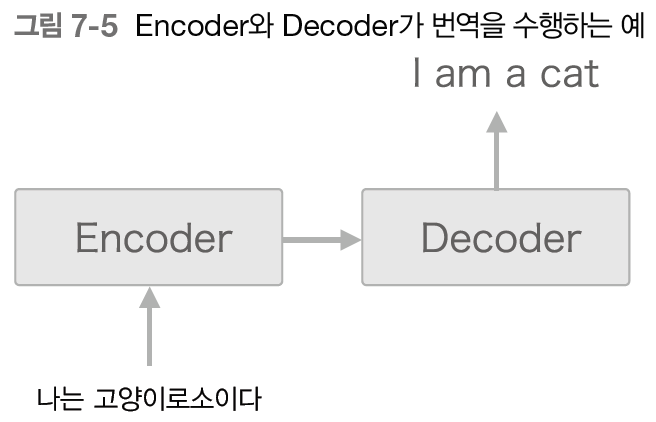

Encoder가 인코딩한 정보에는 번역에 필요한 정보가 조밀하게 응축되어 있다. Decoder는 조밀하게 응축된 이 정보를 바탕으로 도착어 문장을 생성하는 것이다.
이때 Encoder와 Decoder로는 RNN을 사용할 수 있다.

Encoder의 계층은 다음과 같다.

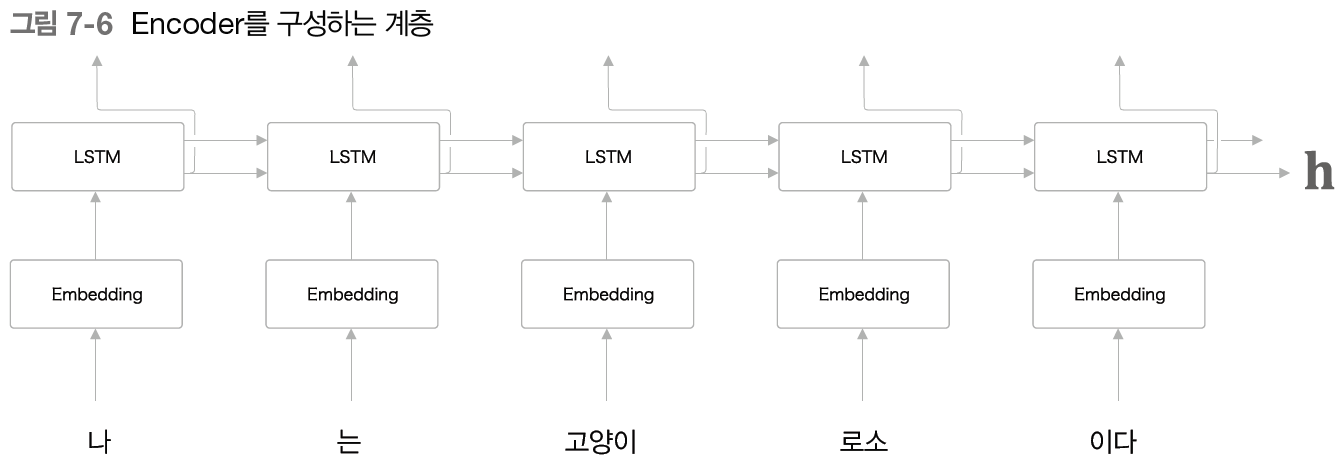

그림처럼 Encoder는 RNN을 이용해 시계열 데이터를 $h$라는 은닉 상태 벡터로 변환한다. 이 마지막 은닉 상태 $h$에 입력 문장(출발어)을 번역하는 데 필요한 정보가 인코딩 된다. 여기서 중요한 점은 LSTM의 은닉 상태 $h$는 고정 길이 벡터라는 점이다. 즉 인코딩한다라 함은 결국 임의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 된다.

Decoder는 앞 절의 신경망과 완전히 같은 구성이다. 단 한가지 바로 LSTM 계층이 벡터 $h$를 입력받는 점만 말고 말이다. (참고로 앞 절의 언어 모델에서는 LSTM 계층이 아무것도 받지 않았다) 그림으로 Decoder의 계층을 확인하자.

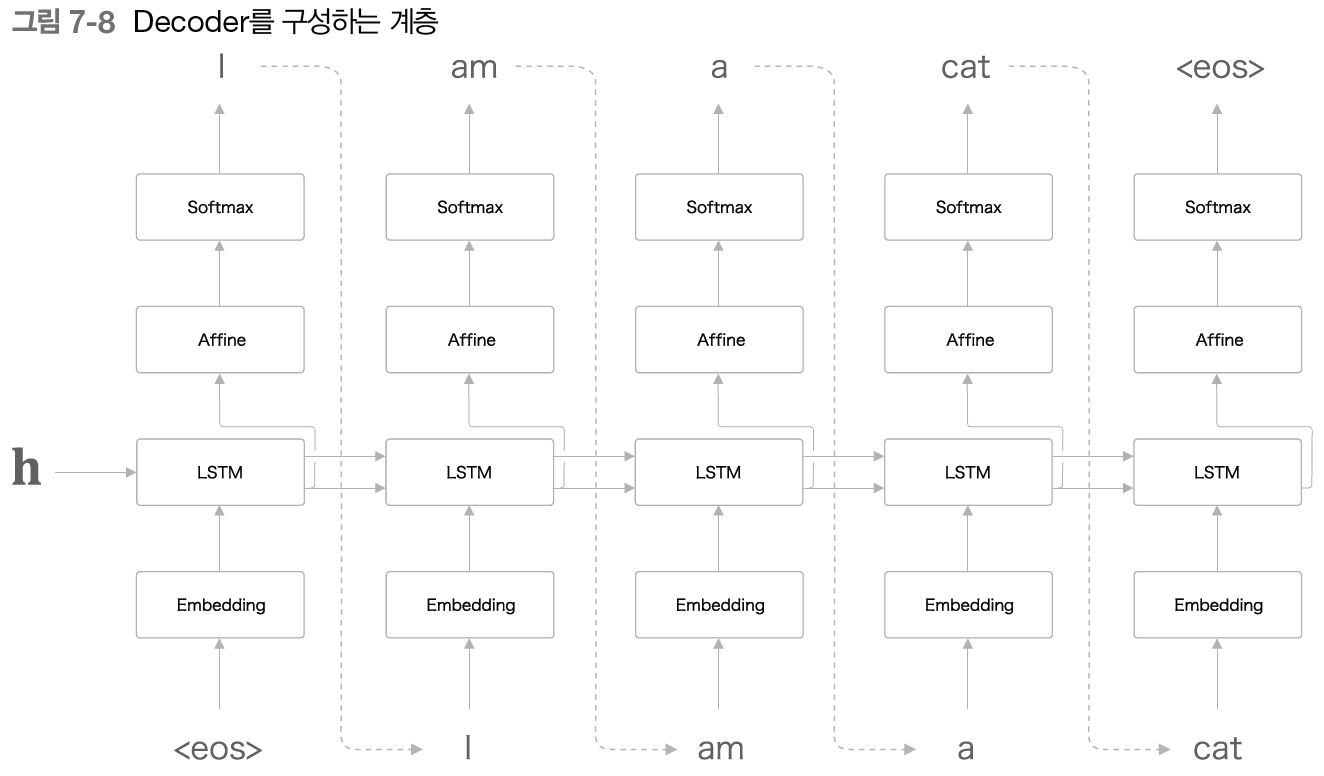

seq2seq는 LSTM 두개로 구성되는데, 이때 LSTM 계층의 은닉 상태가 Encoder와 Decoder를 이어주는 '가교'가 된다. 그림으로 seq2seq의 전체 계층 구성을 확인해보자.

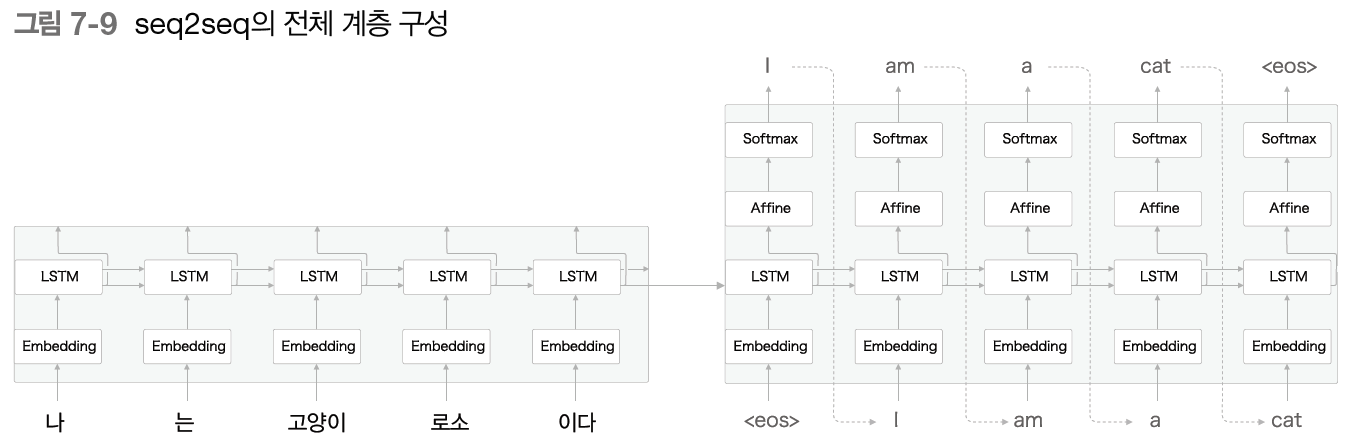

## **시계열 데이터 변환용 장난감 문제**

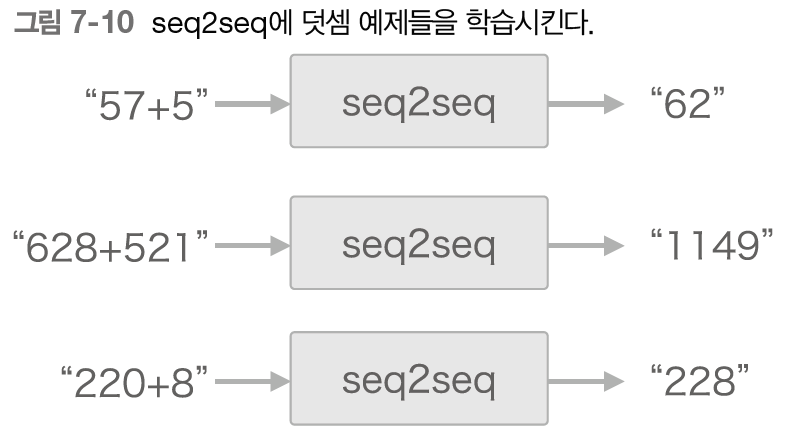

위와 같이 머신러닝을 평가하고자 만든 간단한 문제를 '장난감 문제(toy problem)'이라고 한다.

여기서 다루는 덧셈은 인간에게는 아주 쉬운 문제이지만 seq2seq는 덧셈논리에 대해 아무것도 모른다. seq2seq는 덧셈의 예시로 부터 사용되는 문자의 패턴을 학습한다. 이 점이 바로 이번 문제의 볼거리이다.

그런데 우리는 지금까지 word2vec이나 언어 모델 등에서 문장을 '단어'단위로 분할해왔다. 하지만 문장을 반드시 단어로 분할해야 하는 건 아니다. 실제로 이번 문제에서는 단어가 아닌 '문자'단위로 분할하려 한다. 문자 단위 분할이란, 예컨대 "57+5"가 입력되면 ['5','7','+','5']라는 리스트로 처리하는 걸 말한다.

## **가변 길이 시계열 데이터**

'덧셈' 문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다. '가변 길이 시계열 데이터'를 다룬다는 뜻이다. 따라서 신경망 학습 시 '미니배치 처리'를 하려면 무언가 추가 노력이 필요하게 된다.

가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 **패딩(padding)**을 사용하는 것이다.  모든 입력 데이터의 길이를 통일하고, 남는 공간에는 의미 없는 데이터(예를들어 '공백')를 채우는 방법이다. 그림으로 보자면 다음과 같다.

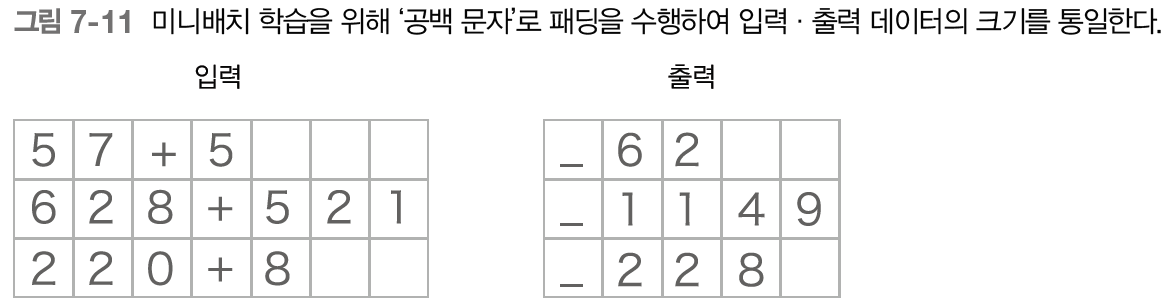

패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시계열 데이터도 처리할 수 있지만 원래 존재하지 않던 패딩용 문자까지 seq2seq가 처리하게 된다. 따라서 패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq에 패딩 전용 처리를 추가해야한다.

예컨대 Decoder에 입력된 데이터가 패딩이라면 손실의 결과에 반영하지 않도록 한다. 한편 Encoder에 입력된 데이터가 패딩이라면 LSTM 계층이 이전 시각의 입력을 그대로 출력하게 한다. 즉, LSTM 계층은 마치 처음부터 패딩이 존재하지 않았던 것처럼 인코딩할 수 있다.

## **덧셈 데이터셋**

'덧셈' 학습 데이터의 실제 사용 예를 살펴보자.

In [12]:
path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝2/deep-learning-from-scratch-2-master'
import sys
sys.path.append(path)
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [13]:
print(x_train[0])
print(t_train[0])

[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]


In [14]:
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

71+118 
_189 


# **seq2seq 구현**

Enocder 클래스와 Decoder 클래스를 RNN으로 각각 구현한 다음, 두 클래스를 연결하는 Seq2seq 클래스를 구현하는 흐름으로 진행한다. Encoder 클래스부터 시작한다.

## **Encoder 클래스**

Encoder 클래스는 Embedding 계층과 LSTM 계층으로 구성되는데, 우리는 시간 방향을 한꺼번에 처리하는 계층을 Time LSTM 계층이나 Time Embedding 계층으로 구현했다. 이러한 Time 계층을 이용하면 우리의 Encoder는 다음과 같다.

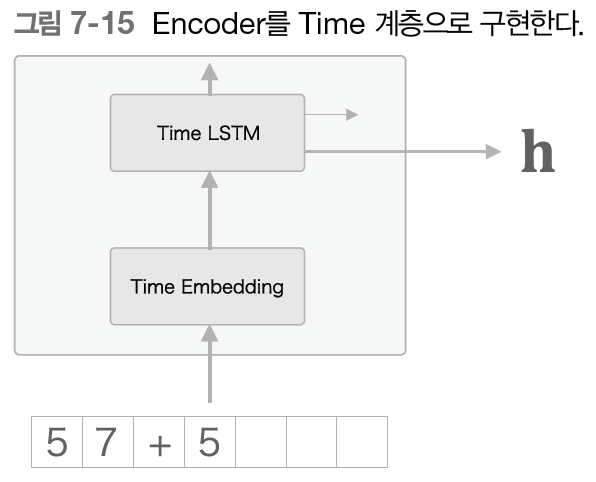

이제 Encoder 클래스를 파이썬 코드로 구현한다.

In [15]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)          # 이번에는 Time LSTM 계층이 상태를 유지하지 않기 때문에 stateful=False로 설정한다.

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## **Decoder 클래스**

Decoder는 RNN으로 구현할 수 있다. Encoder과 마찬가지로 LSTM 계층을 사용하면 되며, 입력으로 Encoder 클래스가 출력한 $h$를 받아 목적으로 하는 다른 문자열을 출력한다. 다음 그림은 학습이 Decoder의 계층 구성이다.

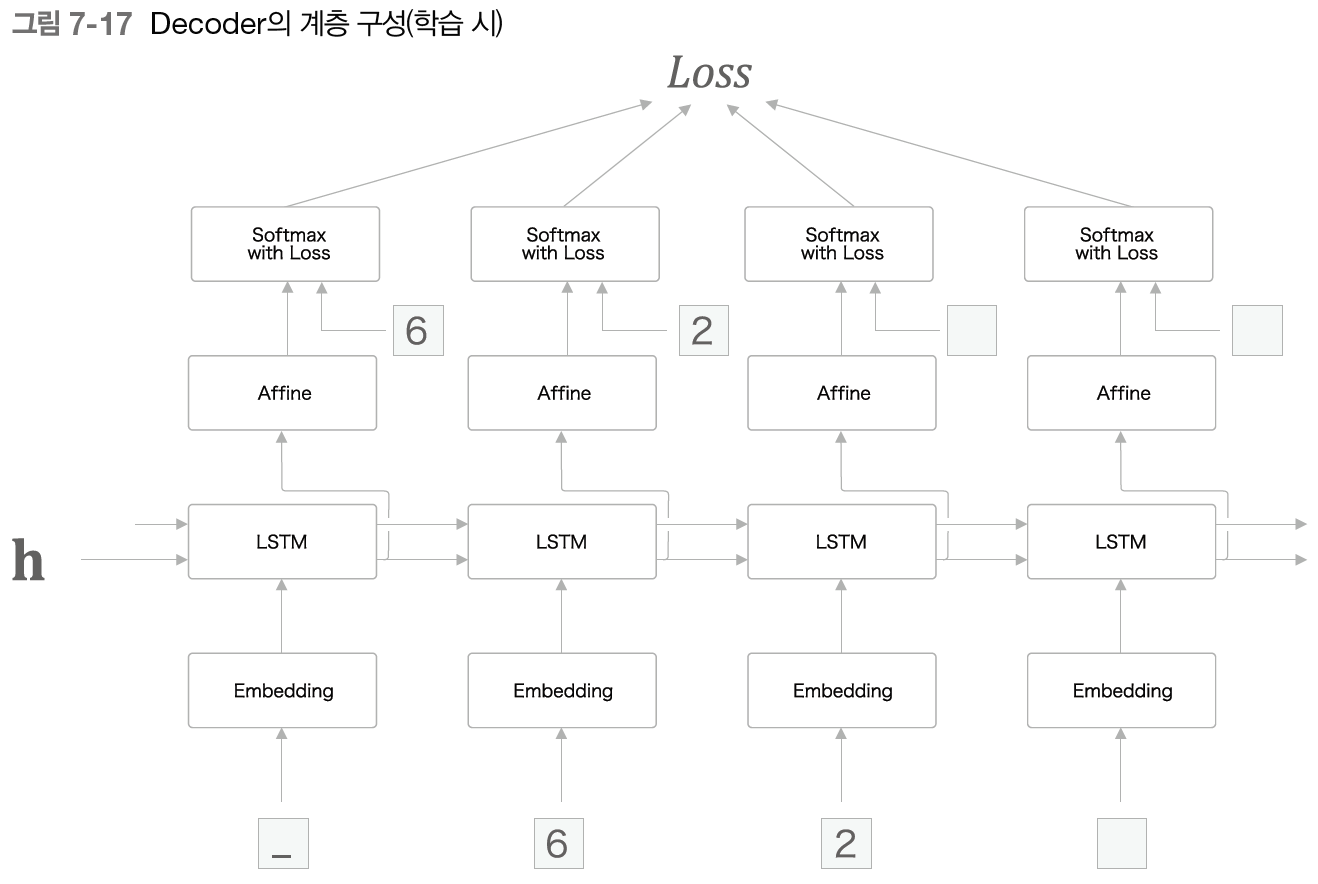

이번 문제는 '덧셈'이므로 확률적인 '비결정성'을 배제하고 '결정적'인 답을 생성하고자 한다. 그래서 이번에는 점수가 가장 높은 문자 하나만 선택한다. 즉 '확률적'이 아닌 '결정적'으로 선택한다. 다음 그림은 Decoder가 문자열을 생성시키는 흐름을 보여준다.

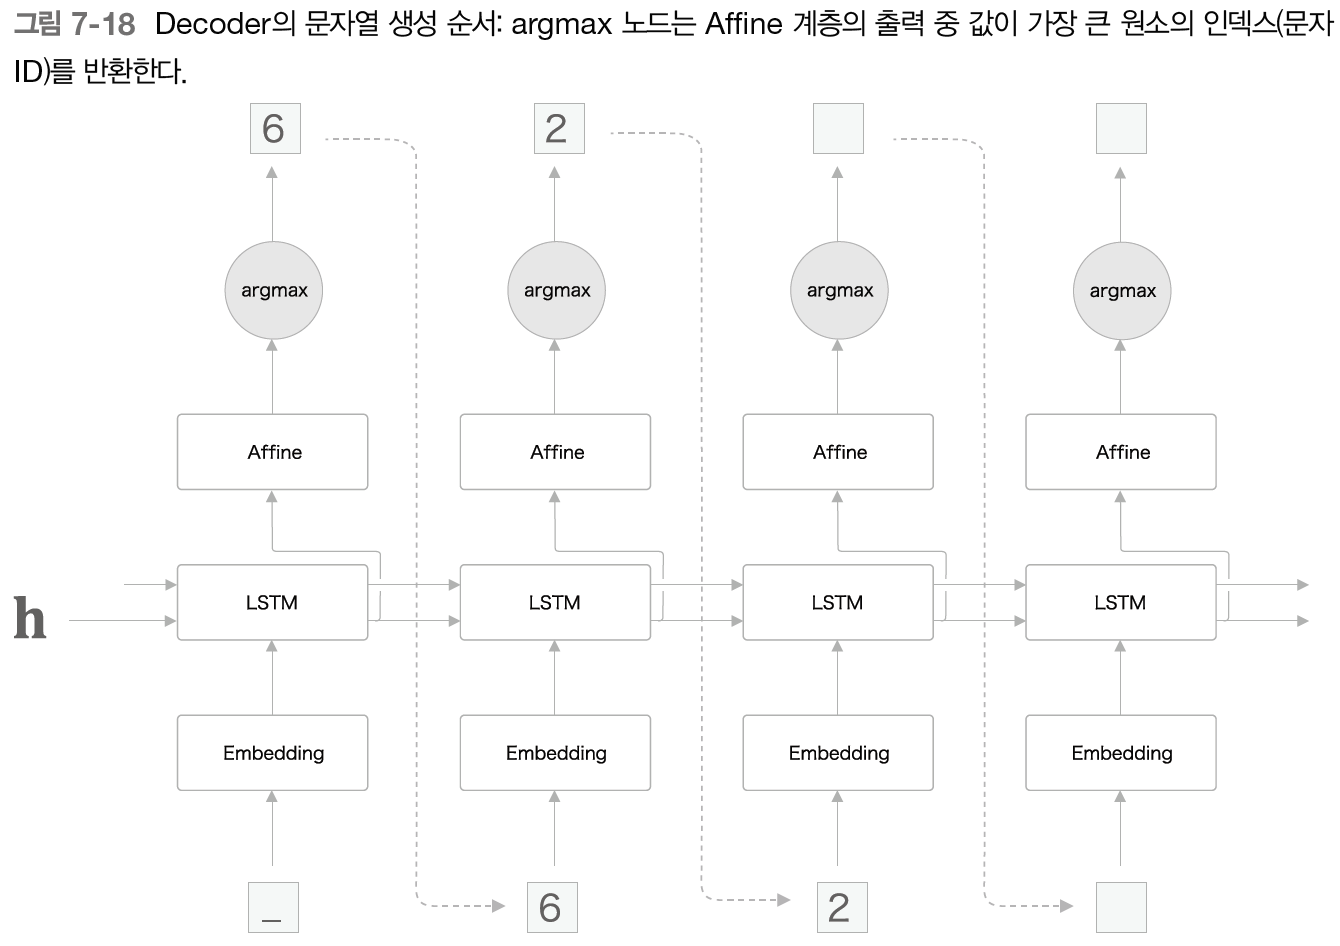

이번에는 Softmax 계층을 사용하지 않고, Affine 계층이 출력하는 점수가 가장 큰 문자 ID를 선택한다. 따라서 Softmax with Loss 계층은 이후에 구현하는 Seq2seq 클래스에서 처리하기로 하고, Decoder 클래스는 위 그림처럼 그 앞까지만 구성한다. Decoder 클래스의 구성을 정리하면 다음과 같다.

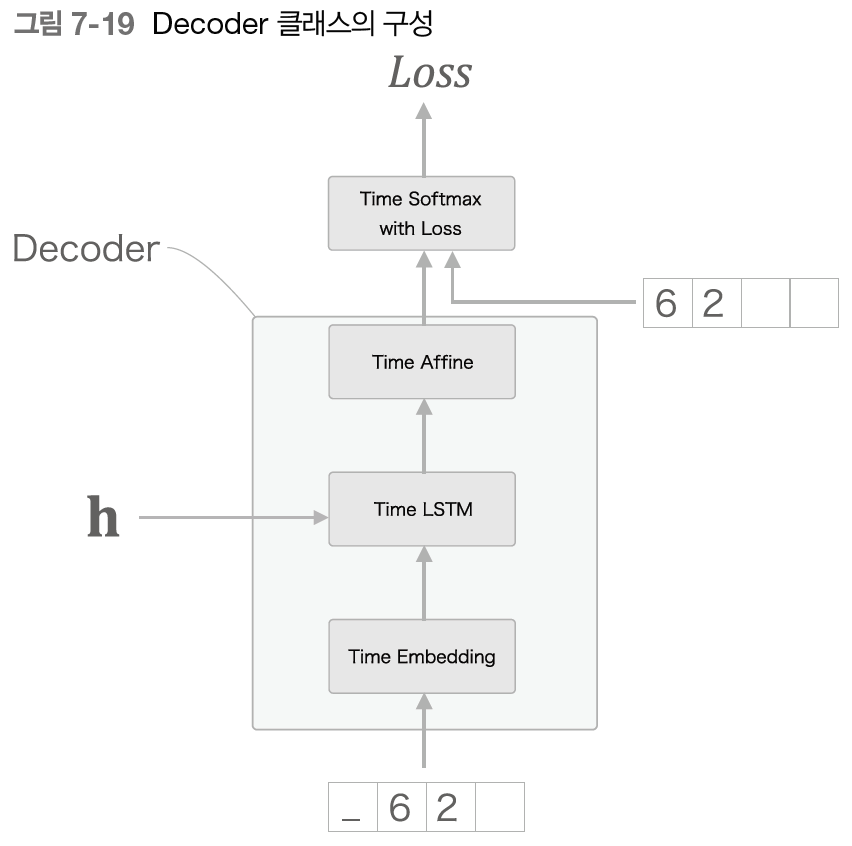

Decoder 클래스의 구현은 다음과 같다.

In [18]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    # 문자 생성 메서드
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

## **Seq2seq 클래스**

마지막으로 Seq2seq 클래스를 구현한다. 이 클래스가 하는 일은 Encoder 클래스와 Decoder 클래스를 연결하고, Time Softmax with Loss 계층을 이용해 손실을 계산하는 것이다. 바로 코드를 보자.

In [20]:
from common.time_layers import *
from common.base_model import BaseModel


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

## **seq2seq 평가**

seq2seq의 학습은 기본적인 신경망의 학습과 같은 흐름으로 이뤄진다.

1. 학습 데이터에서 미니배치를 선택하고,
2. 미니배치로부터 기울기를 계산하고,
3. 기울기를 사용하여 매개변수를 갱신한다.

seq2seq의 학습 코드는 다음과 같다.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 19[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---


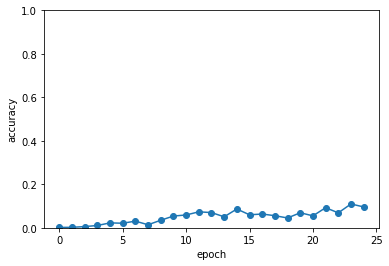

In [23]:
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
# from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

에폭을 거듭함에 따라 정답률이 착실하게 상승하는 것을 알 수 있다. 이번 실험은 25 에폭에서 중단했는데, 그 시점의 정답률은 10% 정도이다. 이 학습은 여기서 끝내고, 같은 문제(덧셈 문제)를 더 잘 학습할 수 있도록 seq2seq를 개선해볼 생각이다.

# **seq2seq 개선**

앞 절의 seq2seq를 세분화하여 학습 '속도'를 개선해보자. 효과적인 기법이 몇 가지 있는데, 그중 두가지 개선안을 소개한다.

## **입력 데이터 반전(Reverse)**

첫 번째 개선안은 아주 쉬운 트릭으로, 입력 데이터의 순서를 반전 시키는 것이다. 이 트릭을 사용하면 많은 경우 진행이 빨라져서, 결과적으로 최종 정확도도 좋아진다고 한다. 실제로 코드를 읽어보자.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 17[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1001
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1001
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---


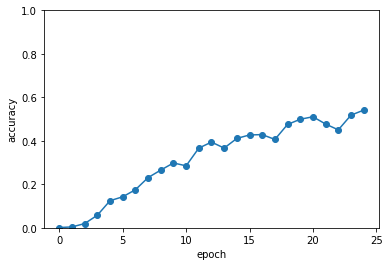

In [30]:
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True                                               # 입력 반전
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

그래프에서 확인 할 수 있듯이, 입력 데이터를 반전시킨 것만으로 학습 진행이 훨씬 개선되었다. 25 에폭에 이르자 정답률은 50% 정도까지나 올랐다. 물론 데이터를 반전시키는 효과는 어떤 문제를 다루느냐에 따라 다르지만, 대부분의 경우 더 좋은 결과로 이어진다.

입력 데이터를 반전시키는 것만으로 학습의 진행이 빨라지고 정확도가 향상되는 직관적인 이유는 기울기 전파가 원활해지기 때문이라고 생각된다.

입력문을 반전시키면, 대응하는 변환 후 단어와 가까우므로(그런 경우가 많으므로) 기울기가 더 잘 전해져서 학습 효율이 좋아진다고 생각된다.

## **엿보기(Peeky)**

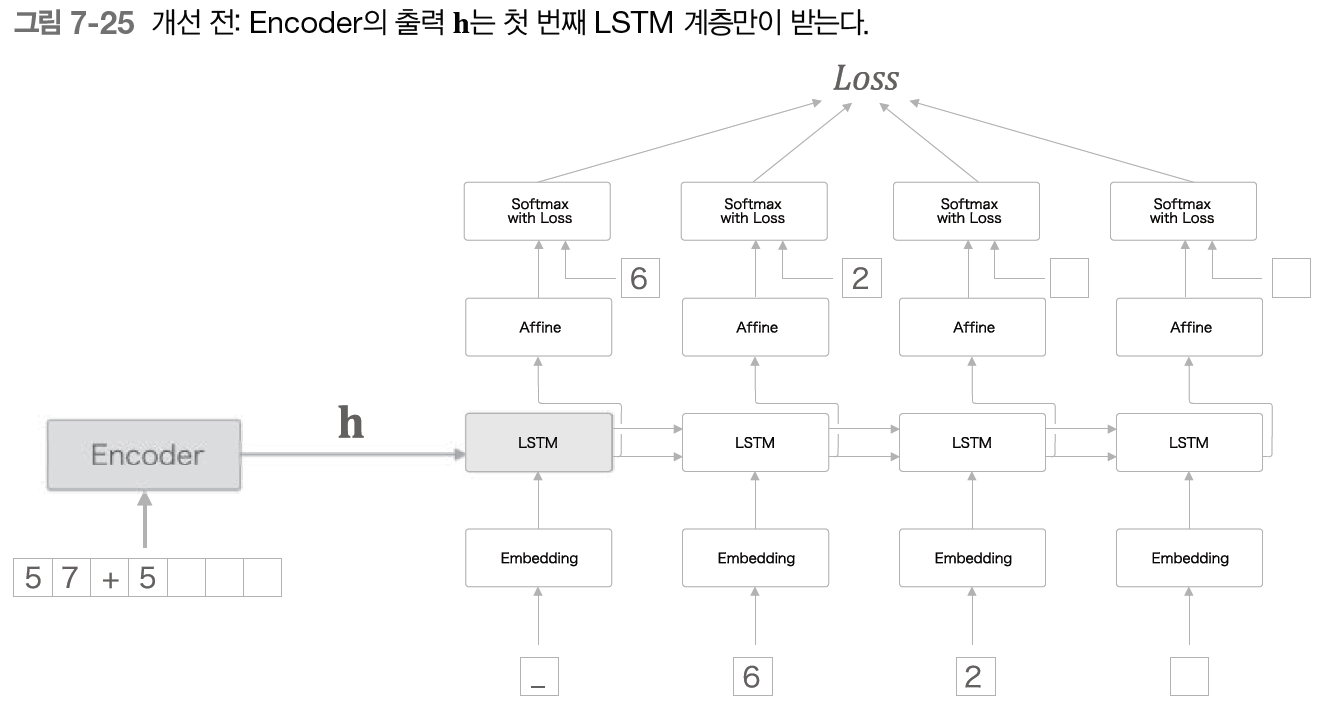

Encoder를 거친 밀집된 중요한 정보인 $h$는 Decoder에 있어서 유일한 정보이다. 허나 현재의 seq2seq는 최초 시각의 LSTM 계층만이 벡터 $h$를 이용하고 있다. 이 중요한 정보인 $h$를 더 활용하기 위해 출력 $h$를 Decoder의 다른 계층에게도 전해주어 중요한 정보를 많은 사람과 공유하여 더 올바른 결정을 내리는 집단지성의 효과를 내는 것이다.

다른 계층도 인코딩된 정보를 '엿본다'라고 해석할 수 있기 때문에 이 개선을 더한 Decoder를 'Peeky Decoder'라고 한다.

이때, LSTM 계층과 Affine 계층에 입력되는 벡터가 2개씩이 되므로, concat 노드를 이용하여 다음 그림처럼 그려야 정확한 계산 그래프가 나온다.

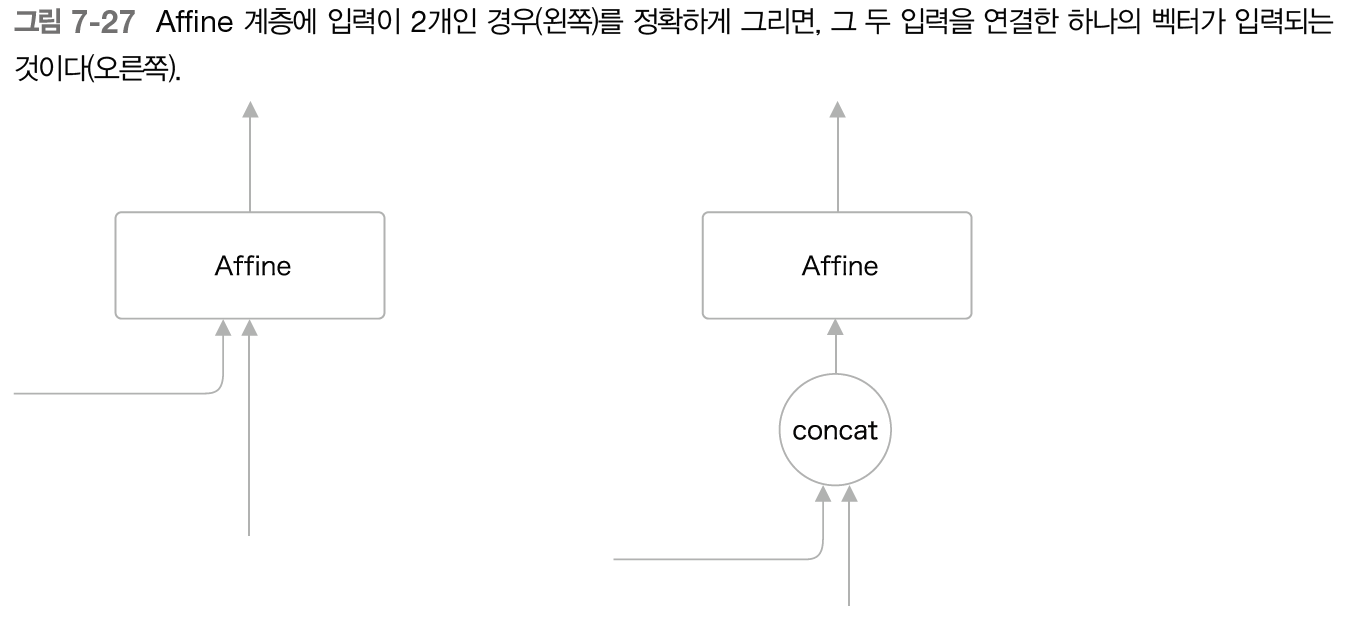

이제, Peeky Decoder 클래스를 구현해보자.

In [25]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled

마지막으로, PeekySeq2seq를 구현하는데 앞 절의 Seq2seq 클래스와 유일한 차이는 Decoder 계층이다. 앞의 Seq2seq클래스가 Decoder 클래스를 사용하던 것에 반해 이번에는 PeekyDecoder를 사용하고 로직을 똑같이 가면 된다. 구현은 다음과 같다.

In [26]:
from ch07.seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

이제 PeekySeq2seq 클래스를 사용하여 덧셈 문제에 다시 도전해보자. 학습용 코드는 앞 절의 코드에서 Seq2seq 클래스만 PeekySeq2seq 클래스로 변경하면 된다. 또 한가지 더, 이번에는 첫 번째 개선인 'Reverse(입력 반전)'도 적용한 후 수행한다.

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 7[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 8[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 9[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 10[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 12[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 17[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 19[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 20[s] | 손실 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1013
---
Q 582+84 
T 666 
☒ 102 
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1023
---
Q 600+257
T 857 
☒ 1023
---
Q 761+292
T 1053
☒ 1023
---
Q 830+597
T 1427
☒ 1111
---

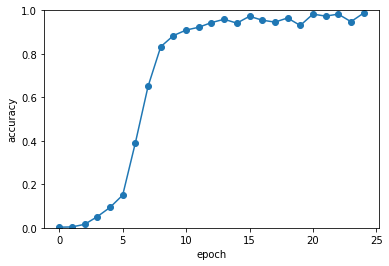

In [29]:
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()

그래프에서 보듯 Peeky를 추가로 적용하자 seq2seq의 결과가 월등히 좋아졌다. 입력문장을 반전시키는 Reverse, 그리고 Encoder의 정보를 널리 퍼지게 하는 Peeky. 이 두 기법 덕분에 우리는 만족할만한 결과를 얻었다.

참고로, Peeky를 이용하게 되면 우리의 신경망은 가중치 매개변수가 커져서 계산량도 늘어나게 된다. 따라서 이번 절의 실험 결과는 커진 매개변수만큼의 '핸디캡'을 감안해야 한다. 또한 seq2seq의 정확도는 하이퍼파라미터에 영향을 크게 받는다. 예제의 결과와는 달리, 실제 문제에서는 그 효과가 달라질 것이다.

# **seq2seq를 이용하는 애플리케이션**

seq2seq는 '한 시계열 데이터'를 '다른 시계열 데이터'로 변환하는 것이다. 이는 다양한 문제에 적용할 수 있다. 다음은 구체적인 예들이다.

* 기계 번역 : '한 언어의 문장'을 '다른 언어의 문장'으로 변환
* 자동 요약 : '긴 문장'을 '짧게 요약된 문장'으로 변환
* 질의 응답 : '질문'을 '응답'으로 변환
* 메일 자동 응답 : '받은 메일의 문장'을 '답변 글'로 변환

이처럼 seq2seq는 2개가 짝을 이루는 시계열 데이터를 다루는 문제에 이용할 수 있다.

## **챗봇**

## **알고리즘 학습**

## **이미지 캡셔닝**

지금까지는 seq2seq가 텍스트를 다루는 예만을 보았다. 하지만 seq2seq는 텍스트 외에도, 이미지나 음성 등 다양한 데이터를 처리할 수 있다. 이번 절에서는 이미지를 문장으로 변환하는 **이미지 캡셔닝(Image Captioning)**을 소개한다.

이미지 캡셔닝은 '이미지'를 '문장'으로 변환한다. 다음 그림과 같이 seq2seq의 틀에서 해결할 수 있다.

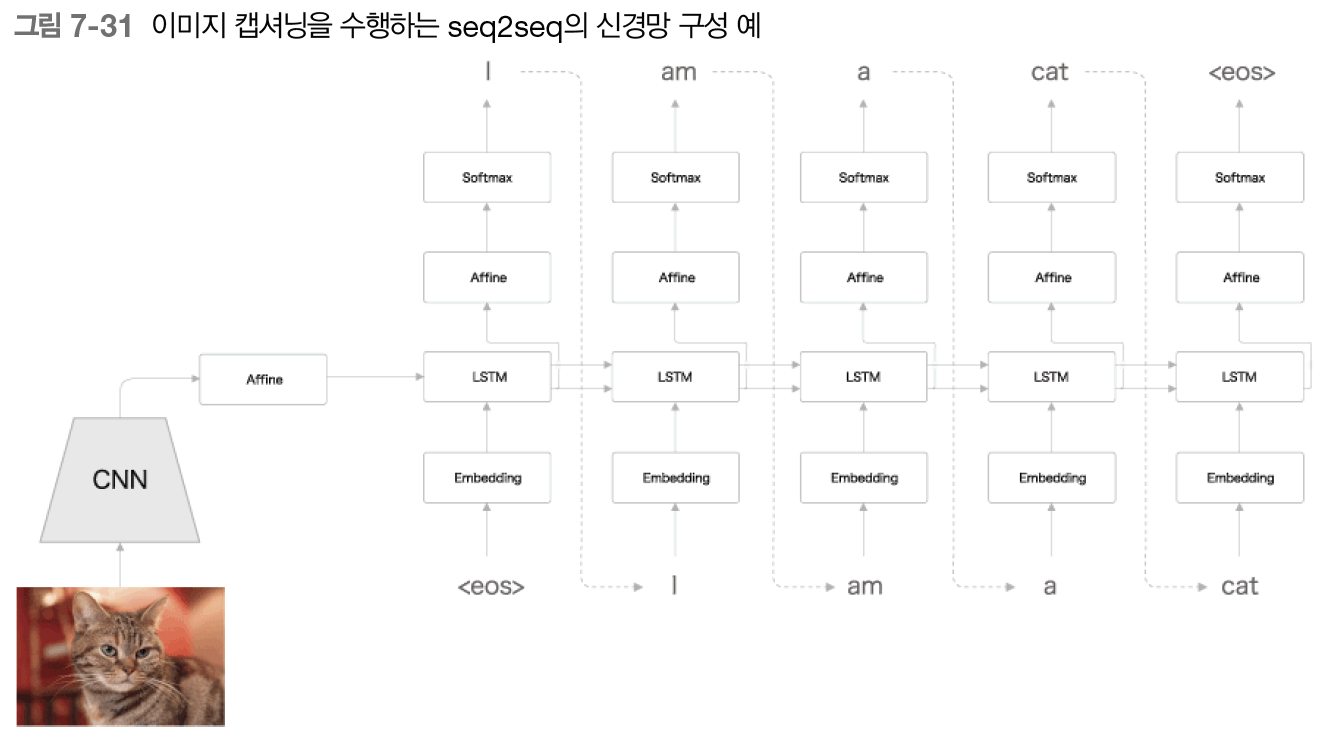

지금까지와 다른 점은 Encoder가 LSTM에서 합성곱 신경망(CNN)으로 바뀐 게 전부이다. 겨우 이정도의 변경만으로, seq2seq는 이미지도 처리할 수 있다. 다음은 이미지 캡셔닝의 몇가지 예이다.

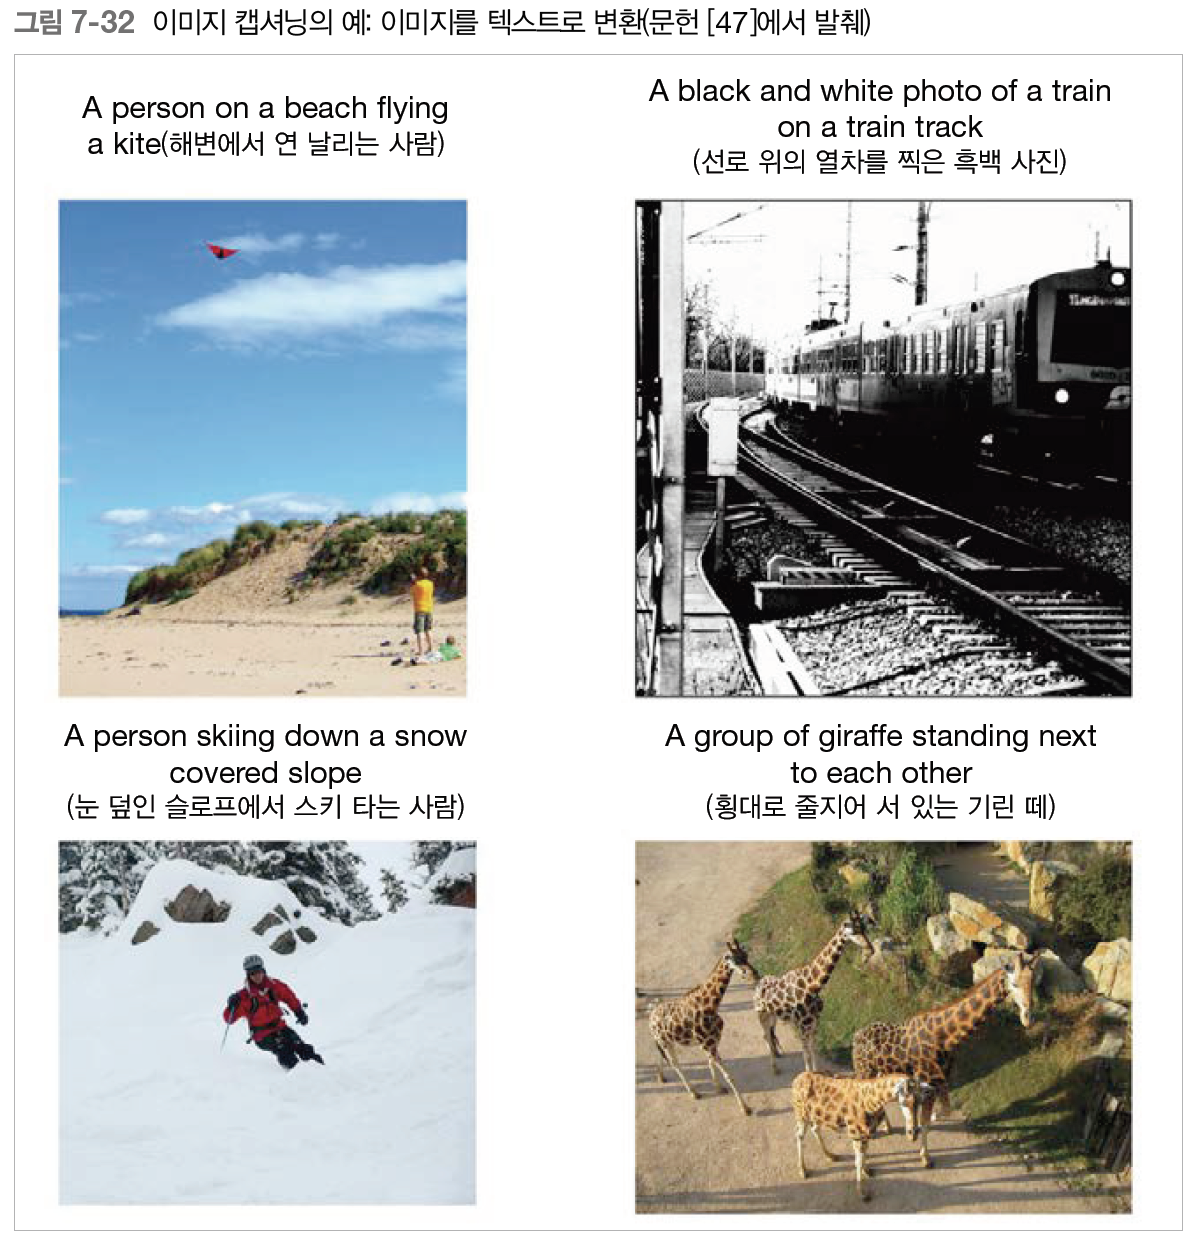

# **정리**

* **RNN을 이용한 언어 모델은 새로운 문장을 생성할 수 있다.**
* **문장을 생성할 때는 하나의 단어(혹은 문자)를 주고 모델의 출력(확률분포)에서 샘플링하는 과정을 반복한다.**
* **RNN을 2개 조합함으로써 시계열 데이터를 다른 시계열 데이터로 변환할 수 있다.**
* **seq2seq는 Encoder가 출발어 입력문을 인코딩하고, 인코딩된 정보를 Decoder가 받아 디코딩하여 도착어 출력문을 얻는다.**
* **입력문을 반전시키는 기법(Reverse), 또는 인코딩된 정보를 Decoder의 여러 계층에 전달하는 기법(Peeky)은 seq2seq의 정확도 향상에 효과적이다.**
* **기계 번역, 챗봇, 이미지 캡셔닝 등 seq2seq는 다양한 애플리케이션에 이용할 수 있다.**